In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchaudio
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
import os
from torchvision import transforms
import torchaudio.transforms as T
from pathlib import Path

from sklearn.model_selection import KFold
from torch.utils.data import Subset


In [30]:
class VocalDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform
        self.classes = ['Laryngozele', 'Normal', 'Vox senilis']
        self.files = []
        for label in self.classes:
            class_path = self.root_dir / label
            self.files += [(f, label) for f in class_path.glob('*.wav')]
        # MelSpectrogram transformation
        self.feature_transform = T.MelSpectrogram()

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        file_path, label = self.files[idx]
        waveform, sample_rate = torchaudio.load(file_path)
        
        if waveform.size(0) > 1:
            waveform = torch.mean(waveform, dim=0, keepdim=True)
        
        features = self.feature_transform(waveform)

        target_length = 128  

        # ? correct dimensions
        if features.size(2) < target_length:
            pad = target_length - features.size(2)
            features = torch.nn.functional.pad(features, (0, pad))
        else:
            features = features[:, :, :target_length]

        if self.transform:
            features = self.transform(features)
        
        label_idx = self.classes.index(label)  
        return features, label_idx


In [31]:
# initing dataset and check feature tensor shape
root_dir = "/kaggle/input/patient-health-detection-using-vocal-audio/patient-vocal-dataset/patient-vocal-dataset"
vocal_dataset = VocalDataset(root_dir=root_dir)

sample_waveform, _ = vocal_dataset[0]  
print(f"Sample waveform shape: {sample_waveform.shape}")


Sample waveform shape: torch.Size([1, 128, 128])


In [32]:

# Initing the DataLoader
dataloader = DataLoader(vocal_dataset, batch_size=32, shuffle=True, collate_fn=lambda x: x)  # Adjust collate_fn if needed

# Print dataset and dataloader info
print(f"Total number of files in dataset: {len(vocal_dataset)}")


Total number of files in dataset: 1036


In [35]:
input_size = 128 * 128  # 16384


In [36]:

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x shape: [batch_size, sequence_length, input_size]
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out


In [41]:

# Parameters for K-Fold
num_folds = 5
batch_size = 32
num_epochs = 10
learning_rate = 0.001

# K-Fold cross-validation
kfold = KFold(n_splits=num_folds, shuffle=True)

# indices for cross-validation splits
indices = list(range(len(vocal_dataset)))

for fold, (train_indices, val_indices) in enumerate(kfold.split(indices)):
    print(f"Fold {fold+1}/{num_folds}")
    
    # my subsets for training and validation
    train_subset = Subset(vocal_dataset, train_indices)
    val_subset = Subset(vocal_dataset, val_indices)
    
    # my DataLoaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    
    # init the model, criterion, and optimizer
    model = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    # Training loop
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        
        for features, labels in train_loader:
            features = features.view(features.size(0), -1, input_size)
            optimizer.zero_grad()
            outputs = model(features)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        epoch_loss = running_loss / len(train_loader)
        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {accuracy:.2f}%")
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        
        for features, labels in val_loader:
            features = features.view(features.size(0), -1, input_size)
            outputs = model(features)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * correct / total
        print(f"Validation Accuracy for Fold {fold+1}: {val_accuracy:.2f}%")
    
    print("-" * 50)

print("Cross-validation complete")


Fold 1/5
Epoch [1/10], Loss: 0.9089, Accuracy: 56.28%
Epoch [2/10], Loss: 0.8272, Accuracy: 65.82%
Epoch [3/10], Loss: 0.8129, Accuracy: 62.56%
Epoch [4/10], Loss: 0.7965, Accuracy: 68.24%
Epoch [5/10], Loss: 0.8053, Accuracy: 66.43%
Epoch [6/10], Loss: 0.7922, Accuracy: 66.18%
Epoch [7/10], Loss: 0.7985, Accuracy: 66.06%
Epoch [8/10], Loss: 0.8022, Accuracy: 65.22%
Epoch [9/10], Loss: 0.7885, Accuracy: 68.84%
Epoch [10/10], Loss: 0.7796, Accuracy: 69.20%
Validation Accuracy for Fold 1: 59.13%
--------------------------------------------------
Fold 2/5
Epoch [1/10], Loss: 0.9016, Accuracy: 52.96%
Epoch [2/10], Loss: 0.8433, Accuracy: 61.28%
Epoch [3/10], Loss: 0.8518, Accuracy: 62.61%
Epoch [4/10], Loss: 0.8385, Accuracy: 59.47%
Epoch [5/10], Loss: 0.8274, Accuracy: 64.54%
Epoch [6/10], Loss: 0.8301, Accuracy: 63.45%
Epoch [7/10], Loss: 0.8241, Accuracy: 65.26%
Epoch [8/10], Loss: 0.8046, Accuracy: 66.83%
Epoch [9/10], Loss: 0.8111, Accuracy: 65.02%
Epoch [10/10], Loss: 0.8187, Accurac

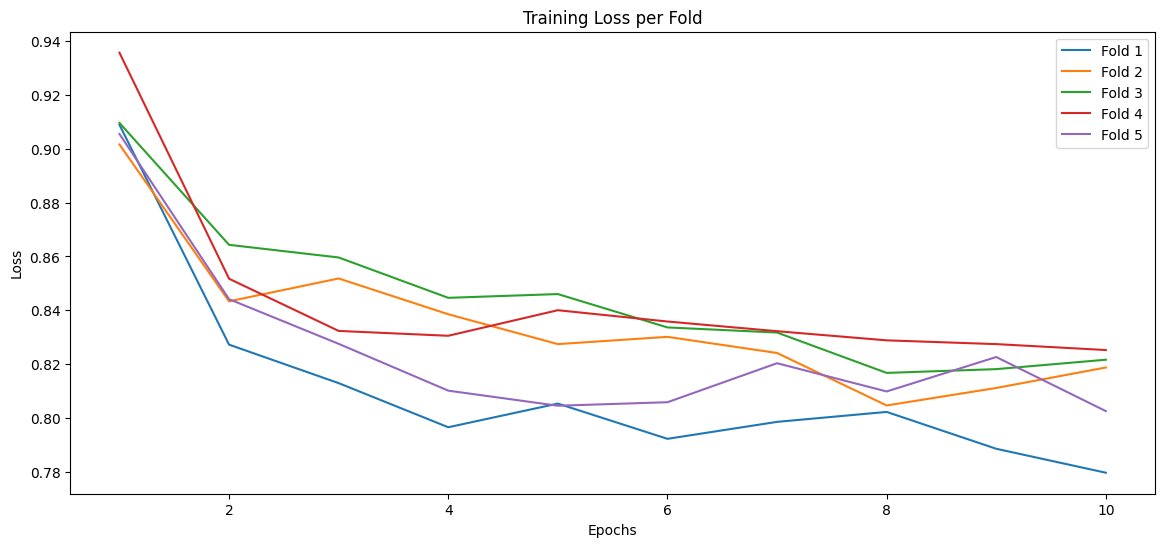

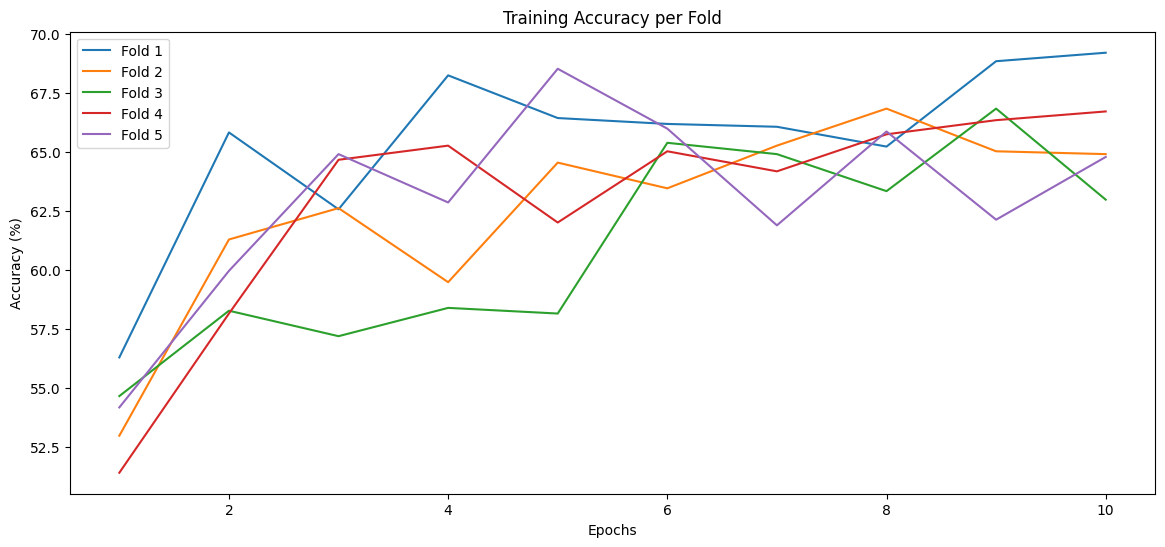

In [44]:

epochs = list(range(1, 11)) 

losses = [
    [0.9089, 0.8272, 0.8129, 0.7965, 0.8053, 0.7922, 0.7985, 0.8022, 0.7885, 0.7796],
    [0.9016, 0.8433, 0.8518, 0.8385, 0.8274, 0.8301, 0.8241, 0.8046, 0.8111, 0.8187],
    [0.9096, 0.8643, 0.8596, 0.8446, 0.8460, 0.8336, 0.8317, 0.8167, 0.8181, 0.8216],
    [0.9357, 0.8517, 0.8323, 0.8305, 0.8400, 0.8358, 0.8322, 0.8288, 0.8274, 0.8252],
    [0.9055, 0.8441, 0.8275, 0.8101, 0.8045, 0.8058, 0.8203, 0.8098, 0.8226, 0.8025]
]

accuracies = [
    [56.28, 65.82, 62.56, 68.24, 66.43, 66.18, 66.06, 65.22, 68.84, 69.20],
    [52.96, 61.28, 62.61, 59.47, 64.54, 63.45, 65.26, 66.83, 65.02, 64.90],
    [54.64, 58.26, 57.18, 58.38, 58.14, 65.38, 64.90, 63.33, 66.83, 62.97],
    [51.39, 58.14, 64.66, 65.26, 62.00, 65.02, 64.17, 65.74, 66.34, 66.71],
    [54.16, 59.95, 64.90, 62.85, 68.52, 65.98, 61.88, 65.86, 62.12, 64.78]
]

#Loss plöt
plt.figure(figsize=(14, 6))
for i, loss in enumerate(losses):
    plt.plot(epochs, loss, label=f'Fold {i + 1}')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Fold')
plt.legend()
plt.show()

# Accuracy plot
plt.figure(figsize=(14, 6))
for i, acc in enumerate(accuracies):
    plt.plot(epochs, acc, label=f'Fold {i + 1}')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training Accuracy per Fold')
plt.legend()
plt.show()
